The 600 first epochs were performed on the reduce dataset (360 000 images). Then to the complete dataset (560 000 images).

With batch size of 640 and 360 000 images in the database, 100 epochs took about 3h (a bit less)
With batch size of 700 and 560 000 images in the database, 100 epochs took about 4h40


WITH METRICS: 200 epochs: Wall time: 11h 33min 22s

Current script load the 'final' weigths (which is save if everything goes well)

Weights are saved every 100 epochs. I should probably keep wieghts each 1000 epochs (depending on how many time it took to treat the whole data set) 139298/139937


Look at the correlation matrix to see if there is a bias in the angle correct prediction. If yes, rebuild the dataset by applying angle of 90/180/270 to try to get something mor or less homogenous
1 step: realign every centriole in a 0->90 orientation

2ns step: perform reorientation. => rotation of 90/180/270 i can also flip the image

Load the 500 epochs save if problem



TO DO:

To check: Note: in train definition i put the model in train mode (model.train() ) I do not change this statut after.

Save the log of accuracy and loss

Save the train_loader and validation_loader to don't have to rebuild them (especially because that lead to mixing each time train and validation set


IMPORTANT: CHANGE PERFORMED ON gestion of classification/Regression problem (modification of n_classes/n_class call in data_agregator and VGG_schmidtea to modify the call of the number of class. MODIFICATION NOT TESTED


In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

import csv
import pickle
import seaborn as sn
import pandas as pd

from sklearn.model_selection import train_test_split

import json
from glob import glob

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
import torch
import torch.nn as nn
import numpy as np
import csv

import import_ipynb

from tools.ToolBox import json_loader
from tools.ToolBox import csv_saver

from tools.CNN_Tools import VGG_Schmidtea
from tools.CNN_Tools import train
from tools.CNN_Tools import validate

from tools.Dataset_Tools import centriole_dataset
from tools.Dataset_Tools import dataset_creator
from tools.Dataset_Tools import dataset_loader
from tools.Dataset_Tools import dataset_aggregator

importing Jupyter notebook from /home/cyril_b/projects/schmidtea/tools/ToolBox.ipynb
importing Jupyter notebook from /home/cyril_b/projects/schmidtea/tools/CNN_Tools.ipynb
importing Jupyter notebook from /home/cyril_b/projects/schmidtea/tools/Dataset_Tools.ipynb


In [2]:
problem = 'regression'
#problem = 'classification'


if problem == 'classification':
    n_class = 72
    
else:
    n_class = 1


In [3]:
# Feature Extracting: we update only the last layer so we set the requires.grad to false
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [4]:
load_dataset = True

# Creation/Loading of the Dataset
if load_dataset == False:   
    train_loader, validation_loader = dataset_creator(path_json = './data_json/',
                                                     batch_size = 700,
                                                     n_class = n_class,
                                                     save_dataset = True)  
elif problem == 'classification':
    train_loader, validation_loader = dataset_loader(path = './data/',
                                                     train_set = 'train_loader_dataset_b700_unNormalized.pth',
                                                     val_set = 'validation_loader_dataset_b700_unNormalized.pth')
    
else: 
    train_loader, validation_loader = dataset_loader(path = './data/',
                                                 train_set = 'train_data_pregression_b700_unNormalized.pth',
                                                 val_set = 'validation_data_pregression_b700_unNormalized.pth')

    

In [5]:
load_weight = True
problem = 'regression'


# For feature extraction: only the last layer is updated
feature_extract = True


if torch.cuda.is_available():                                  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)


# Criterion and CNN loading
if problem == 'classification':
    criterion = nn.CrossEntropyLoss()
    model = VGG_Schmidtea(n_classes = n_class)#.to(device)
else: 
    criterion = nn.MSELoss()
    model = VGG_Schmidtea(n_classes = 72)#.to(device)
    model = VGG_Schmidtea(n_classes = 72)#.to(device)

    
criterion = nn.MSELoss()
# Weight loading
if load_weight == True:
    #model.load_state_dict(torch.load('./weight/VGG_schmidtea_weigth_epoch_regression800.pth'))
    model.load_state_dict(torch.load('./weight/VGG_schmidtea_weigth_epoch_600.pth'))

    set_parameter_requires_grad(model, feature_extract)
    model.classifier[8] = nn.Linear(4096, 1)
    model.to(device)

    
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    


# Oprimizer loading
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)


Using PyTorch version: 1.6.0  Device: cuda
Params to learn:
	 classifier.8.weight
	 classifier.8.bias


In [6]:
%%time

# Define the number of epochs to train the model
epochs = 10
performed_epochs = 600


# Let's Train!!
for epoch in range(1, epochs + 1):
    # Instantiate variable to log loss and accuracy
    acct, losst, accv, lossv,cmt, cmv  = [], [], [], [], [], []
    
    train(model, losst, acct, cmt, train_loader, device, problem, criterion, optimizer, epoch, n_class)    
    validate(model, lossv, accv, cmv, validation_loader, device, problem, criterion, n_class)
    
    if epoch%100 == 0:
        torch.save(model.state_dict(),('./weight/VGG_schmidtea_weigth_epoch_regression' + str(epoch+performed_epochs) + '.pth'))
    
    """
    csv_saver(accv , './metrics/accv.csv')
    csv_saver(lossv, './metrics/lossv.csv')
    csv_saver(acct , './metrics/acct.csv')
    csv_saver(losst, './metrics/losst.csv')
    csv_saver(cmt  , './metrics/cmt.csv')
    csv_saver(cmv  , './metrics/cmv.csv')
    """
    
    
#torch.save(model.state_dict(),('VGG_schmidtea_weigth_epoch_final.pth'))

Train Epoch: 1 [0/559746 (0%)]	Loss: 1.422309

Training set: Average loss: 1.2772, Accuracy 5 : 29.0%, Accuracy 2.5 : 16.6, Accuracy 1 : 0.6
Validation set: Average loss: 1.1781, Accuracy 5 : 29.1%, Accuracy 2.5 : 16.7, Accuracy 1 : 0.4

Train Epoch: 2 [0/559746 (0%)]	Loss: 1.196950

Training set: Average loss: 1.1071, Accuracy 5 : 29.1%, Accuracy 2.5 : 17.5, Accuracy 1 : 0.4
Validation set: Average loss: 1.0452, Accuracy 5 : 29.1%, Accuracy 2.5 : 18.1, Accuracy 1 : 0.4

Train Epoch: 3 [0/559746 (0%)]	Loss: 1.091345

Training set: Average loss: 1.0051, Accuracy 5 : 29.3%, Accuracy 2.5 : 18.6, Accuracy 1 : 0.4
Validation set: Average loss: 0.9657, Accuracy 5 : 29.5%, Accuracy 2.5 : 18.9, Accuracy 1 : 0.5

Train Epoch: 4 [0/559746 (0%)]	Loss: 0.999322

Training set: Average loss: 0.9426, Accuracy 5 : 29.7%, Accuracy 2.5 : 19.1, Accuracy 1 : 0.4
Validation set: Average loss: 0.9173, Accuracy 5 : 30.0%, Accuracy 2.5 : 19.2, Accuracy 1 : 0.5

Train Epoch: 5 [0/559746 (0%)]	Loss: 0.892461

T

In [13]:
print(n_class)

72


##### 

In [8]:
torch.save(model.state_dict(),('./weigth/VGG_schmidtea_weigth_epoch_regression' + str(epoch+performed_epochs) + '.pth'))
torch.save(model.state_dict(),('./weigth/VGG_schmidtea_weigth_epoch_' + str(epoch+performed_epochs) + '.pth'))


FileNotFoundError: [Errno 2] No such file or directory: './weigth/VGG_schmidtea_weigth_epoch_regression100.pth'

In [9]:
torch.save(model.state_dict(),('./hello.pth'))

In [16]:
a_list = list([accv[-1]])
print(a_list)

[tensor(66.2634)]


# ADD CONFUSION MATRIX IN REGISTERED METRICS

In CNN_TOOLS , add conf_matrix as arguments and add the arguments here too

<AxesSubplot:>

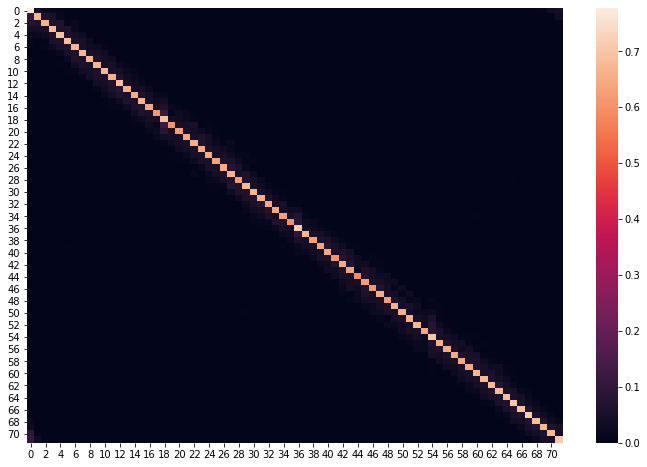

In [16]:
confusion_matrix = torch.zeros(n_class, n_class)

#model.load_state_dict(torch.load('./weight/VGG_schmidtea_weigth_epoch_1200.pth'))

for batch_idx, batch in enumerate(validation_loader):
    # Copy data to GPU if needed
    img = batch['image'].float().to(device)
    angle = batch['angle'].long().to(device)

    with torch.no_grad():   
        output = model(img)  

    # get the index of the max log-probability
    pred_angle = output.max(1)[1]

    for a, p in zip(angle.view(-1), pred_angle.view(-1)):
        confusion_matrix[a.long(), p.long()] +=1
            
# Data in %
col_sum = confusion_matrix.numpy().sum(axis=1)
col_sum = np.reshape(col_sum, [n_class, -1])

confusion_matrix = confusion_matrix / col_sum
    
df_cm = pd.DataFrame(confusion_matrix.numpy())

plt.figure(figsize = (12,8))
sn.heatmap(df_cm)

In [68]:
for i in range(72):
    print("Number of {} : {}".format(i, angle_db.count(i)))

Number of 0 : 27307
Number of 1 : 13143
Number of 2 : 12712
Number of 3 : 13954
Number of 4 : 14446
Number of 5 : 15857
Number of 6 : 15962
Number of 7 : 14603
Number of 8 : 12594
Number of 9 : 14435
Number of 10 : 12117
Number of 11 : 11927
Number of 12 : 11003
Number of 13 : 9682
Number of 14 : 9047
Number of 15 : 8741
Number of 16 : 8737
Number of 17 : 7498
Number of 18 : 10872
Number of 19 : 6322
Number of 20 : 6103
Number of 21 : 6087
Number of 22 : 6000
Number of 23 : 6648
Number of 24 : 6917
Number of 25 : 7067
Number of 26 : 6948
Number of 27 : 8728
Number of 28 : 8583
Number of 29 : 8860
Number of 30 : 8359
Number of 31 : 7039
Number of 32 : 6237
Number of 33 : 5130
Number of 34 : 4483
Number of 35 : 3748
Number of 36 : 7302
Number of 37 : 3989
Number of 38 : 3910
Number of 39 : 4184
Number of 40 : 4275
Number of 41 : 4767
Number of 42 : 4838
Number of 43 : 4511
Number of 44 : 3945
Number of 45 : 5024
Number of 46 : 4306
Number of 47 : 4531
Number of 48 : 4612
Number of 49 : 4

=======================================

In [ ]:
class My_loss_function(nn.Module):
    
    def __init__(self):
        super(My_loss_function, self).__init__()
        
    def forward(self, output, labels):
        labels = labels.view(-1)

In [11]:
#dataset_train = centriole_dataset(img_db = x_train, angle_db = y_train)
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(len(dataset_train)):
    sample = dataset_train[i+10]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('angle {}°'.format(int(sample['angle'])))
    ax.axis('off')
    show_centriole(np.array(sample['image'], dtype = 'uint8'))

    if i == 3:
        plt.show()
        break


NameError: name 'dataset_train' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
dataset_test = centriole_dataset(img_db = x_test, angle_db = y_test)


fig = plt.figure()

for i in range(len(dataset_test)):
    sample = dataset_test[i+10]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('angle {}°'.format(int(sample['angle'])))
    ax.axis('off')
    show_centriole(np.array(sample['image'], dtype = 'uint8'))

    if i == 3:
        plt.show()
        break
